# Remote sensing, satellite imagery, and map visualizations in Python

A very quick primer on a few data sources and basic issues, and some practical uses of Python.

Stephen Klosterman, steve.klosterman@gmail.com

Technical note:  see here for the command to install cartopy in anaconda python
http://scitools.org.uk/cartopy/docs/v0.15/installing.html

and here for folium
https://anaconda.org/ioos/folium


## Two basic data types

Vector (i.e. points, lines, polygons) and raster (bitmapped image)

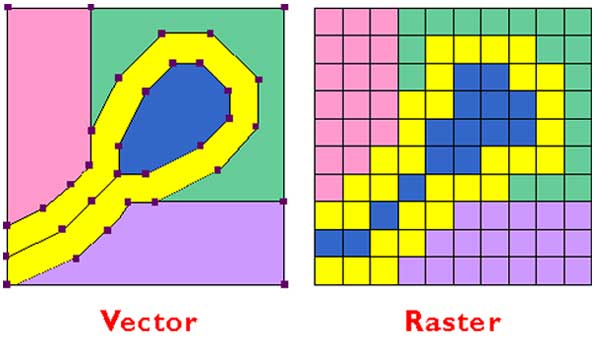

In [29]:
from IPython.display import Image
Image('img/17-1-vector-vs-raster.jpg')    

## What kind of data is out there?

Two of the dominant players in the remote sensing game are MODIS and Landsat.  They illustrate several basic issues in remote sensing:

1.  Spatial/temporal tradeoff:  MODIS has high temporal resolution (daily) but low spatial (>= 250m), Landsat is the other way (~weekly, 30m)
2.  Clouds:  in passive remote sensing of the earth surface (relies on measuring the reflectance of incoming sunlight at various wavelengths), clouds mean you can't see the earth.
3.  Spectral resolution:  both of these platforms have several bands, including the R, G, B bands of visible light, as well as some infrared bands useful for other purposes, i.e. thermal data.

Google either one of these for more info.  The data for both is freely available online and python-based access is shown here
https://github.com/lucadelu/pyModis/blob/master/docs/source/examples/pyModis.ipynb
and here
https://github.com/ceholden/landsat_preprocess/tree/c313e36dc0ba840c468d86aea751196119b88555/chapters

Now to look at some implementations of mapping and visualzation:

## Overlaying remote sensing imagery on a basemap

The image here was generated in Matlab, but should be possible in Python.  It shows how MODIS images from different times of year can illustrate seasonal change across the landscape:  https://github.com/klostest/CS109/blob/master/CS_109_Final_Project_Final_12_12_13.ipynb

## General mapping function for a world map
Colors by country:
https://github.com/klostest/diet-and-health/blob/master/diet-and-health.ipynb

## Interactive map in Python
Nearly directly copied and pasted from
https://ocefpaf.github.io/python4oceanographers/blog/2015/02/02/cartopy_folium_shapefile/

Other resources
1.  Looks very useful as well, for general description of the formats that folium works with http://nbviewer.jupyter.org/gist/psychemedia/fbcd7cf1daabe0004e27/folium_shapefiles.ipynb
2.  Number 1 was found from a descriptive blog post here
https://blog.ouseful.info/2015/04/17/creating-interactive-election-maps-using-folium-and-ipython-notebooks/
3.  This student at Boston U seems to have tons of interesting free/open GIS software
http://ceholden.github.io/repos/

In [1]:
from cartopy.io import shapereader


kw = dict(resolution='50m', category='cultural',
          name='admin_1_states_provinces')

states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

#Download took ~ 1 min

/Users/Steve/anaconda2/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


In [17]:
from __future__ import unicode_literals

states = ('Minas Gerais', 'Mato Grosso', 'Goiás',
          'Bahia', 'Rio Grande do Sul', 'São Paulo')

# states = ('California', 'Nevada', 'Arizona')

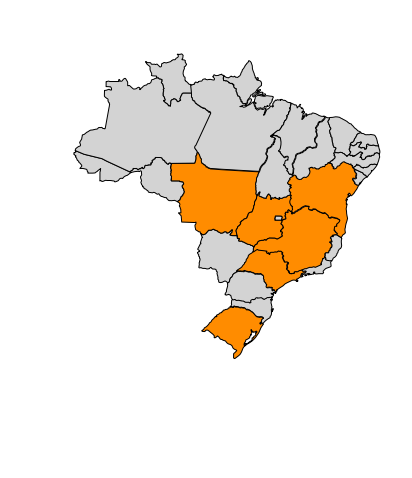

In [18]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


subplot_kw = dict(projection=ccrs.PlateCarree())

fig, ax = plt.subplots(figsize=(7, 11),
                       subplot_kw=subplot_kw)
ax.set_extent([-82, -32, -45, 10])
# ax.set_extent([-126, -108, 30, 43])

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

for record, state in zip(shp.records(), shp.geometries()):
    name = record.attributes['name'].decode('latin-1')
    if name in states:
        facecolor = 'DarkOrange'
    else:
        facecolor = 'LightGray'
    ax.add_geometries([state], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor='black')
    
plt.show()

In [19]:

import os
import shapefile
from json import dumps


def shape2json(fname, outfile="states.json", country='Brazil'):
    reader = shapefile.Reader(fname)
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]

    data = []
    for sr in reader.shapeRecords():
        atr = dict(zip(field_names, sr.record))
        geom = sr.shape.__geo_interface__
        if country in sr.record[field_names.index('admin')]:
            name = sr.record[field_names.index('name')].decode('latin-1')
            if name in states:
                data.append(dict(type="Feature", geometry=geom, properties=atr))
            
    keys = ['abbrev', 'name', 'name_alt']
    for b in data:
        for key in keys:
            b['properties'][key] = b['properties'][key].decode('latin-1')

    with open(outfile, "w") as geojson:
        geojson.write(dumps({"type": "FeatureCollection",
                             "features": data}, indent=2) + "\n")


shape = '50m_admin_1_states_provinces.shp'
cartopy_cache = '.local/share/cartopy/shapefiles/natural_earth/cultural/'
fname = os.path.join(os.path.expanduser('~'), cartopy_cache, shape)

shape2json(fname, outfile="states.json", country='Brazil')

In [22]:
#conda install -c ioos folium=0.2.1
import folium
import numpy as np
from IPython.display import IFrame


def inline_map(m, width=650, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed

bbox = [-82, -32, -45, 10]

lon_center, lat_center = np.array(bbox).reshape(2, 2).mean(axis=0)
mapa = folium.Map(width=650, height=500, zoom_start=4,
                  location=[-15, -50])

mapa.geo_json(geo_path='states.json', fill_color='none', line_color='Orange')

#Doesn't seem to work:
# inline_map(mapa)
# mapa.Chloropleth()

#But this did
mapa